## Assignment 3: Stance classification

##### Group Name: SKN

1. Kuvalaya Datta Jukanti
2. Shreyash Sankay Kad

In [13]:
import pandas as pd
import io
import numpy as np
import re
import string
from google.colab import files
from sklearn.model_selection import train_test_split, cross_validate

In [46]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [54]:
!pip install emoji
import emoji

     |████████████████████████████████| 133kB 12.6MB/s 


In [14]:
train_file_uploaded = files.upload()

Saving a3_train_final.tsv to a3_train_final (1).tsv


In [32]:
data = pd.read_table(io.BytesIO(train_file_uploaded['a3_train_final.tsv']), header=None)

In [33]:
data.rename(columns = {0:'label', 1: 'comment'}, inplace = True) 

In [34]:
data.head()

,label,comment
0,0/-1,It is easier to fool a million people than it...
1,0/0,NATURAL IMMUNITY protected us since evolutio...
2,0/-1,NATURAL IMMUNITY protected us since evolutio...
3,1/-1,The bigest sideffect of vaccines is fewer dea...
4,0/-1,90% of people that get vaccinated don't get th...


In [35]:
len(data)

8788

In [37]:
label_col = data['label']


In [38]:
# Function to determine which value to be chosen from the label column.
for i in range(len(label_col)):
    rating = label_col[i]
    # print(rating)
    rating = rating.split("/")

    cnt_pro = 0
    cnt_anti = 0
    cnt_unknown = 0
    
    for k in rating:
        
        
        if k == '0':
            cnt_anti += 1
        elif k == '1':
            cnt_pro += 1
        else:
            cnt_unknown += 1
    
    
    if cnt_pro > cnt_anti and cnt_pro > cnt_unknown:
        label_col[i] = 1

    elif cnt_anti > cnt_pro and cnt_anti > cnt_unknown:
        label_col[i] = 0

    elif cnt_unknown > cnt_pro and cnt_unknown > cnt_anti:
        label_col[i] = -1

    else:
        label_col[i] = int(rating[-1])



The function picks a value which is repeated most number of times in the label list separated by slash. If the values are tied, it picks the newest annotation made i.e. the last value in the list.

For example, for a label 0/0/1,  the function picks '0' as it is repeated more number of times. For a case where the label is 0/1, the values are tied. It picks the latest annotations i.e. 1.

In [39]:
label_col.value_counts()

 1    4109
 0    3909
-1     770
Name: label, dtype: int64

We observe that number of instances for pro-vaccine(0) and anti-vaccine(0) are almost same. So we can say that the dataset is balanced.

In [40]:
data['label'] = label_col

Dropping the rows with label -1 as it is just approx 9% of entire dataset

In [41]:
# Dropping -1 
data = data.drop(data.index[data['label'] == -1], inplace=False)

In [42]:
data['label'].unique()

array([0, 1], dtype=object)

## Preprocessing

### Contractions

This section will expand the contraction words like "aren't" which will be replaced by cannot. This is done because when apostrophes are removed in punctuation removal, the word will "aren't" will become "arent" and we need to keep the meaning of the original word. So we created a dictionary and used the dictionary to expand the contractions. This dictionary is also available on internet openly for users to use it.

In [43]:
contractions = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not"
}

In [44]:
def expand_contractions(text, cs_dict):
    contractions_pattern = re.compile('({})'.format('|'.join(cs_dict.keys())), flags=re.IGNORECASE | re.DOTALL)
 
    def expand_match(contraction):
        match = contraction.group(0)
        expanded_contraction = cs_dict.get(match) if cs_dict.get(match) else cs_dict.get(match.lower())
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)

    return expanded_text

### For stopwords

In [47]:
from nltk.corpus import stopwords
nltk_stopwords = set(stopwords.words('english'))

In [48]:
# Checking Nltk's stop words list
nltk_stopwords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

NLTK's stopwords contains words which are most probably important for the classification task. Words such as "wasn't", "no", "not", "against" and so on might be helpful in recognizing anti-vaccine comments.

In [49]:
# checking the count of each stop word in training dataset
stop_words_counts = {}
for i in nltk_stopwords:
  stop_words_counts[i] = data.comment.str.count(i).sum()


In [50]:
# Displaying the stopword and count in ascending order of the stop word
{k: v for k, v in sorted(stop_words_counts.items(), key=lambda item: item[1])}

{'a': 64190,
 'about': 580,
 'above': 11,
 'after': 347,
 'again': 284,
 'against': 158,
 'ain': 695,
 'all': 2039,
 'am': 1331,
 'an': 11154,
 'and': 4546,
 'any': 932,
 'are': 2174,
 'aren': 170,
 "aren't": 35,
 'as': 3865,
 'at': 7946,
 'be': 3839,
 'because': 365,
 'been': 444,
 'before': 170,
 'being': 262,
 'below': 4,
 'between': 21,
 'both': 102,
 'but': 769,
 'by': 386,
 'can': 1121,
 'couldn': 21,
 "couldn't": 15,
 'd': 27571,
 'did': 190,
 'didn': 77,
 "didn't": 45,
 'do': 2701,
 'does': 236,
 'doesn': 128,
 "doesn't": 73,
 'doing': 103,
 'don': 956,
 "don't": 434,
 'down': 152,
 'during': 38,
 'each': 79,
 'few': 134,
 'for': 2662,
 'from': 786,
 'further': 5,
 'had': 616,
 'hadn': 1,
 "hadn't": 1,
 'has': 549,
 'hasn': 30,
 "hasn't": 19,
 'have': 1638,
 'haven': 60,
 "haven't": 35,
 'having': 130,
 'he': 15155,
 'her': 1989,
 'here': 814,
 'hers': 165,
 'herself': 2,
 'him': 34,
 'himself': 5,
 'his': 2033,
 'how': 457,
 'i': 57424,
 'if': 1135,
 'in': 19359,
 'into': 191,

In [51]:
# Displaying stop word and name in descending order of counts
for i in sorted(stop_words_counts, key=stop_words_counts.get, reverse=True):
  print(i, stop_words_counts[i])

t 72835
a 64190
o 59369
i 57424
s 46946
d 27571
in 19359
m 18308
y 18024
he 15155
the 11205
an 11154
re 9420
on 9047
at 7946
or 7049
it 7002
to 6955
ve 6843
is 6757
ll 5653
and 4546
no 4092
as 3865
be 3839
me 3764
of 3205
so 2800
do 2701
for 2662
you 2605
ma 2549
are 2174
all 2039
his 2033
her 1989
that 1958
we 1922
not 1872
my 1723
have 1638
this 1524
am 1331
our 1308
out 1256
will 1240
with 1158
if 1135
can 1121
they 987
don 956
any 932
now 866
here 814
very 789
from 786
up 779
but 769
your 734
than 732
ain 695
was 628
who 624
had 616
about 580
just 574
has 549
other 528
more 500
over 497
some 473
what 459
how 457
been 444
don't 434
them 419
their 395
by 386
there 385
when 367
because 365
own 353
after 347
she 342
should 331
only 329
again 284
won 283
then 278
too 276
its 275
nor 271
these 270
being 262
it's 250
does 236
why 229
those 212
ours 210
were 201
most 197
into 191
under 190
did 190
off 182
which 172
before 170
aren 170
hers 165
against 158
down 152
once 147
won't 138
few 13

In [52]:
exclude = ['against','aren',"aren't",'not','but','ain','how','what','don',"don't",'why','too','nor',"won't",'doesn','having','isn',"doesn't",'didn',"isn't",'haven',"didn't","haven't", "wouldn't",'hasn','wasn','couldn','shouldn',"hasn't","couldn't","shouldn't","wasn't",'weren', "weren't" ]

In [53]:
# removing words from stop words list which are in "exclude" list
for i in exclude:
  nltk_stopwords.remove(i)

### Emoji Conversion

In [55]:
#"emoji" package contains demojize function that converts emoji to words describing it
def emoji_convert(dataset):
  dataset.comment = dataset.comment.apply(lambda x: emoji.demojize(x))
  return dataset.copy()

### Common preprocessing for all models

Changing every word to its lowercase, removing punctions and expanding contraction

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import re
import string

In [57]:
def pre_process(text):
  text = text.lower()     # Lowering the case
  text = expand_contractions(text, contractions)   # Expanding contractions
  text = text.replace('[^\w\s]','')     # Removing punctuations

  return text


In [58]:
data['comment'] = data['comment'].apply(np.vectorize(pre_process))
data['comment'] = data['comment'].str.replace('[{}]'.format(string.punctuation), ' ')   # Removing punctuations
data['comment'] = data['comment'].str.replace('[{}]'.format(string.digits), ' ')   # Removing numbers


In [59]:
data.comment

1        natural immunity  protected us since evolutio...
5             effective against the original strain an...
6                  appears safe    yeh think i will pass 
7       both nhs workers have a history of serious all...
8       covid arm is a new rash like side effect appea...
                              ...                        
8783                                                   💉💪
8784                           😐its gonna be a no for me 
8785    🤣 keep your 💩 i already know   people who have...
8786    🤣🤣🤣  just because it is safe  does not mean it...
8787    🤨there is people already having severe side ef...
Name: comment, Length: 8018, dtype: object

## Models

We will train on four classification algorithms namely, linearSVC, Logistic regression, Bernouilli's Naive Bayes, and stochastic gradient descent algorithms and will compare their performance on validation set. Each model is trained in four different ways 
1. Keeping Emoji and keeping stop words
2. Keeping emoji and removing stop words
3. Converting emoji to words and removing stop words
4. Converting emoji and removing stop words. 

This is done to check which method is better for which model.

In [60]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

### Linear SVC

In [61]:
from sklearn.svm import LinearSVC

#### Emoji conversion and no stop word removal

In [62]:
training = data.copy()
training =emoji_convert(training)
training['comment'] = training['comment'].str.replace('[{}]'.format(string.punctuation), ' ')   # Removing punctuations
X = training['comment']
Y = training['label']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=0)
Ytrain = Ytrain.astype('int')
Ytest = Ytest.astype('int')

In [63]:
training

,label,comment
1,0,natural immunity protected us since evolutio...
5,1,effective against the original strain an...
6,0,appears safe yeh think i will pass
7,1,both nhs workers have a history of serious all...
8,0,covid arm is a new rash like side effect appea...
...,...,...
8783,1,syringe flexed biceps
8784,0,neutral face its gonna be a no for me
8785,0,rolling on the floor laughing keep your pil...
8786,0,rolling on the floor laughing rolling on the...


In [64]:
lsvc_pipeline = make_pipeline( 
              TfidfVectorizer(stop_words=None, ngram_range=(1, 2)), 
              LinearSVC(random_state=42)
          )

lsvc_pipeline.fit(Xtrain, Ytrain)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('linearsvc',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,

##### Classification report

In [65]:
print("Linear SVC with no stop words")
Ypred = lsvc_pipeline.predict(Xtest)
lsvc_emoji = classification_report(Ypred, Ytest)
print(lsvc_emoji)

Linear SVC with no stop words
              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1131
           1       0.86      0.81      0.84      1275

    accuracy                           0.83      2406
   macro avg       0.83      0.83      0.83      2406
weighted avg       0.83      0.83      0.83      2406



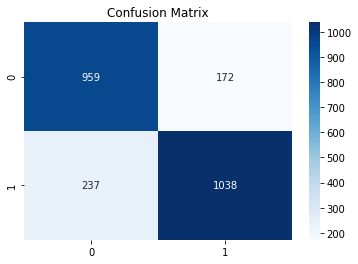

In [66]:
cm = confusion_matrix(lsvc_pipeline.predict(Xtest), Ytest)
ax = plt.axes()
sns.heatmap(cm, annot=True, annot_kws={"size": 10}, fmt='d',cmap="Blues", ax = ax )
ax.set_title('Confusion Matrix')
plt.show()

#### Comments on what erros that the model has done and what might have gone wrong

In [67]:
# Errors for pro-vaccination
for i in range(len(Ypred)):
  if Ypred[i] != Ytest.values[i] and Ytest.values[i]==1:
    print(Xtest.values[i])
    print('---')

go and vaccine ur family
---
because the mrna approach to vaccines is new  you might have seen claims and worries about what might happen after it’s injected into the body 
---
im saving this to share when people who ask me if im getting the vaccination   i love how you broke it down into understandable info   i had an idea of how this all worked  this gave me lots of   thats how that is connected   lol now im able to share info with ones who want to learn   thank you 
---
vaccines are meant to attack the host  so your body s immune system learns to defend itself against the actual virus  this is why antivaxxers are a thing because they believe that big pharm and governments are trying to kill them  but fact is they are too uneducated
---
i hate to tell you this  but everyone being vaccinated will not make americans normal 
---
uhhhhh they will be the ones alive you idiot 
---
I am not antivax but I am concerned about ingredients as i am in everything i put in my body  because in the p

In [68]:
# Errors for anti-vaccination
for i in range(len(Ypred)):
  if Ypred[i] != Ytest.values[i] and Ytest.values[i]==0:
    print(Xtest.values[i])
    print('---')

noooooo thank you      
---
so by the time you are unlucky enough to get globalist vaccine the mutations will be so powerful that vaccine will be rendered useless and while they are telling you how bad you want the shot you know it is bs  where is the flu where d it go  huh   
---
i found an anti vax shirt for kids  and i wondered if there were any in adult sizes  but i realized it would be pointless
---
i am very skeptical of it  i’m sorry i won’t get the vaccine  thats just my opinion
---
not vaccinating your kids only works fine so long as everyone around them is vaccinated 
---
i am more  scared  of the vaccine than i am of dying from covid  yeah  well said 
---
two mice are in the pub and one says “hey  have you had the new covid vaccine yet ” and the other replies“what   are you frickin crazy  they haven’t finished the human trials yet  ”
---
i like how this video supposed to make you feel like it’s no big deal get the vaccine but i’m like i didn’t want it before and now i don’t 

#### No Emoji conversion and stop word removal

In [69]:
training = data.copy()
X = training['comment']
Y = training['label']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=0)
Ytrain = Ytrain.astype('int')
Ytest = Ytest.astype('int')

In [70]:
lsvc_pipeline = make_pipeline( 
              TfidfVectorizer(stop_words=nltk_stopwords, ngram_range=(1, 2)), 
              LinearSVC(random_state=42)
          )

lsvc_pipeline.fit(Xtrain, Ytrain)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'all', 'am',...
                                             'do', 'does', 'doing', 'down',
                                             'during', ...},
                                 strip_accents=None, sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer

##### Classification report

In [72]:
print("Linear SVC with no stop words")
lsvc_sw = classification_report(lsvc_pipeline.predict(Xtest), Ytest)
print(classification_report(lsvc_pipeline.predict(Xtest), Ytest))

Linear SVC with no stop words
              precision    recall  f1-score   support

           0       0.80      0.83      0.81      1163
           1       0.83      0.81      0.82      1243

    accuracy                           0.82      2406
   macro avg       0.82      0.82      0.82      2406
weighted avg       0.82      0.82      0.82      2406



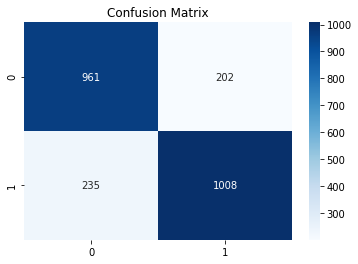

In [73]:
cm = confusion_matrix(lsvc_pipeline.predict(Xtest), Ytest)
ax = plt.axes()
sns.heatmap(cm, annot=True, annot_kws={"size": 10}, fmt='d',cmap="Blues", ax = ax )
ax.set_title('Confusion Matrix')
plt.show()

#### Emoji conversion and stop word removal

In [74]:
training = data.copy()
training =emoji_convert(training)
training['comment'] = training['comment'].str.replace('[{}]'.format(string.punctuation), ' ')   # Removing punctuations
X = training['comment']
Y = training['label']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=0)
Ytrain = Ytrain.astype('int')
Ytest = Ytest.astype('int')

In [75]:
lsvc_pipeline = make_pipeline( 
              TfidfVectorizer(stop_words=nltk_stopwords, ngram_range=(1, 2)), 
              LinearSVC(random_state=42)
          )

lsvc_pipeline.fit(Xtrain, Ytrain)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'all', 'am',...
                                             'do', 'does', 'doing', 'down',
                                             'during', ...},
                                 strip_accents=None, sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer

##### Classification report

In [76]:
print("Linear SVC with no stop words")
lsvc_emoji_sw =classification_report(lsvc_pipeline.predict(Xtest), Ytest)
print(classification_report(lsvc_pipeline.predict(Xtest), Ytest))

Linear SVC with no stop words
              precision    recall  f1-score   support

           0       0.80      0.83      0.81      1162
           1       0.83      0.81      0.82      1244

    accuracy                           0.82      2406
   macro avg       0.82      0.82      0.82      2406
weighted avg       0.82      0.82      0.82      2406



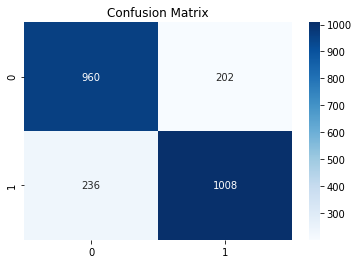

In [77]:
cm = confusion_matrix(lsvc_pipeline.predict(Xtest), Ytest)
ax = plt.axes()
sns.heatmap(cm, annot=True, annot_kws={"size": 10}, fmt='d',cmap="Blues", ax = ax )
ax.set_title('Confusion Matrix')
plt.show()

#### No Emoji conversion and no stop word removal

In [78]:
training = data.copy()
X = training['comment']
Y = training['label']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=0)
Ytrain = Ytrain.astype('int')
Ytest = Ytest.astype('int')

In [79]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix


In [80]:
lsvc_pipeline = make_pipeline( 
              TfidfVectorizer(stop_words=None, ngram_range=(1, 2)), 
              LinearSVC(random_state=42)
          )

lsvc_pipeline.fit(Xtrain, Ytrain)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('linearsvc',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,

##### Classification report

In [81]:
print("Linear SVC with no stop words")
print(classification_report(lsvc_pipeline.predict(Xtest), Ytest))
lsvc_no = classification_report(lsvc_pipeline.predict(Xtest), Ytest)

Linear SVC with no stop words
              precision    recall  f1-score   support

           0       0.80      0.85      0.83      1130
           1       0.86      0.82      0.84      1276

    accuracy                           0.83      2406
   macro avg       0.83      0.83      0.83      2406
weighted avg       0.83      0.83      0.83      2406



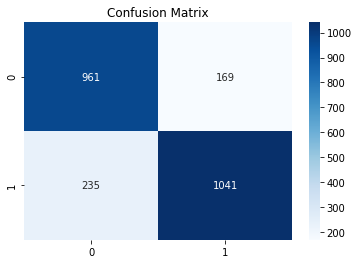

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(lsvc_pipeline.predict(Xtest), Ytest)
ax = plt.axes()
sns.heatmap(cm, annot=True, annot_kws={"size": 10}, fmt='d',cmap="Blues", ax = ax )
ax.set_title('Confusion Matrix')
plt.show()

### Finding feature importances

In [83]:
feature_names = lsvc_pipeline.named_steps["tfidfvectorizer"].get_feature_names()
# print(len(feature_names))
importances = lsvc_pipeline.steps[1][1].coef_
print(importances)

[[-0.19307581 -0.19307581 -0.33311744 ... -0.28706544 -0.24680605
  -0.24680605]]


In [84]:
df = pd.DataFrame(columns=["feature_names", "importances"])
df["feature_names"] = feature_names
df["importances"] = importances[0]
# print(len(importances))
# df

In [85]:
df.sort_values(by='importances',ascending=False)

,feature_names,importances
22864,hope,1.876005
60401,yes,1.698532
20505,great,1.695464
54881,vaccinated,1.587498
55047,vaccination,1.527133
...,...,...
1872,am not,-2.000214
38710,poison,-2.026200
33305,no,-2.264533
32965,never,-2.472106


## Observations made for Linear SVC classifier

In [86]:
#converting emoji to words and not removing stop words
print(lsvc_emoji)

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1131
           1       0.86      0.81      0.84      1275

    accuracy                           0.83      2406
   macro avg       0.83      0.83      0.83      2406
weighted avg       0.83      0.83      0.83      2406



In [87]:
#Converting emojis to words and removing stop words
print(lsvc_emoji_sw)

              precision    recall  f1-score   support

           0       0.80      0.83      0.81      1162
           1       0.83      0.81      0.82      1244

    accuracy                           0.82      2406
   macro avg       0.82      0.82      0.82      2406
weighted avg       0.82      0.82      0.82      2406



In [88]:
#Keeping emojis and stop word
print(lsvc_no)

              precision    recall  f1-score   support

           0       0.80      0.85      0.83      1130
           1       0.86      0.82      0.84      1276

    accuracy                           0.83      2406
   macro avg       0.83      0.83      0.83      2406
weighted avg       0.83      0.83      0.83      2406



In [89]:
#keeping emojis and removing stop words
print(lsvc_sw)

              precision    recall  f1-score   support

           0       0.80      0.83      0.81      1163
           1       0.83      0.81      0.82      1243

    accuracy                           0.82      2406
   macro avg       0.82      0.82      0.82      2406
weighted avg       0.82      0.82      0.82      2406



**By going through all the classification report for linear SVC, removing stop words reduces the quality of the model. So the linear SVC model (without removing stop words and converting emoji's to word) can accurately predict 80% of anti-vaccine cases and accurately predict 86% of pro-vaccine case. In addition, the model can detect 85% of total anti-vaccine cases and 81% total pro-vaccine. By keeping emoji, we can get same performance but support for both cases in former model is more balanced.**

### Logistic Regression

In [90]:
from sklearn.linear_model import LogisticRegression

#### Emoji conversion and no stop word removal

In [91]:
training = data.copy()
training =emoji_convert(training)
training['comment'] = training['comment'].str.replace('[{}]'.format(string.punctuation), ' ')   # Removing punctuations
X = training['comment']
Y = training['label']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=0)
Ytrain = Ytrain.astype('int')
Ytest = Ytest.astype('int')

In [92]:
lr_pipeline = make_pipeline( 
              TfidfVectorizer(stop_words=None, ngram_range=(1, 2)), 
              LogisticRegression(random_state=42)
          )

lr_pipeline.fit(Xtrain, Ytrain)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercep

##### Classification report

In [93]:
print("Logistic Regression with no stop words removed: ")
print(classification_report(lr_pipeline.predict(Xtest), Ytest))
lr_emoji = classification_report(lr_pipeline.predict(Xtest), Ytest)

Logistic Regression with no stop words removed: 
              precision    recall  f1-score   support

           0       0.78      0.83      0.80      1125
           1       0.84      0.79      0.82      1281

    accuracy                           0.81      2406
   macro avg       0.81      0.81      0.81      2406
weighted avg       0.81      0.81      0.81      2406



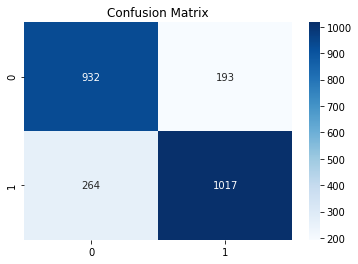

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(lr_pipeline.predict(Xtest), Ytest)
ax = plt.axes()
sns.heatmap(cm, annot=True, annot_kws={"size": 10}, fmt='d',cmap="Blues", ax = ax ) 
ax.set_title('Confusion Matrix')
plt.show()

#### No Emoji conversion and stop word removal

In [96]:
training = data.copy()
X = training['comment']
Y = training['label']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=0)
Ytrain = Ytrain.astype('int')
Ytest = Ytest.astype('int')

In [97]:
lr_pipeline = make_pipeline( 
              TfidfVectorizer(stop_words=nltk_stopwords, ngram_range=(1, 2)), 
              LogisticRegression(random_state=42)
          )

lr_pipeline.fit(Xtrain, Ytrain)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'all', 'am',...
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                        

##### Classification report

In [98]:
print("Logistic Regression with no stop words removed: ")
print(classification_report(lr_pipeline.predict(Xtest), Ytest))
lr_sw=classification_report(lr_pipeline.predict(Xtest), Ytest)

Logistic Regression with no stop words removed: 
              precision    recall  f1-score   support

           0       0.79      0.82      0.81      1159
           1       0.83      0.80      0.81      1247

    accuracy                           0.81      2406
   macro avg       0.81      0.81      0.81      2406
weighted avg       0.81      0.81      0.81      2406



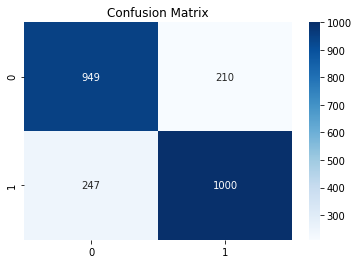

In [99]:
cm = confusion_matrix(lr_pipeline.predict(Xtest), Ytest)
ax = plt.axes()
sns.heatmap(cm, annot=True, annot_kws={"size": 10}, fmt='d',cmap="Blues", ax = ax )
ax.set_title('Confusion Matrix')
plt.show()

#### Emoji conversion and stop word removal

In [101]:
training = data.copy()
training =emoji_convert(training)
training['comment'] = training['comment'].str.replace('[{}]'.format(string.punctuation), ' ')   # Removing punctuations
X = training['comment']
Y = training['label']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=0)
Ytrain = Ytrain.astype('int')
Ytest = Ytest.astype('int')

In [102]:
lr_pipeline = make_pipeline( 
              TfidfVectorizer(stop_words=nltk_stopwords, ngram_range=(1, 2)), 
              LogisticRegression(random_state=42)
          )

lr_pipeline.fit(Xtrain, Ytrain)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'all', 'am',...
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                        

##### Classification report

In [103]:
print("Logistic Regression with no stop words removed: ")
print(classification_report(lr_pipeline.predict(Xtest), Ytest))
lr_emoji_sw = classification_report(lr_pipeline.predict(Xtest), Ytest)

Logistic Regression with no stop words removed: 
              precision    recall  f1-score   support

           0       0.79      0.82      0.80      1159
           1       0.82      0.80      0.81      1247

    accuracy                           0.81      2406
   macro avg       0.81      0.81      0.81      2406
weighted avg       0.81      0.81      0.81      2406



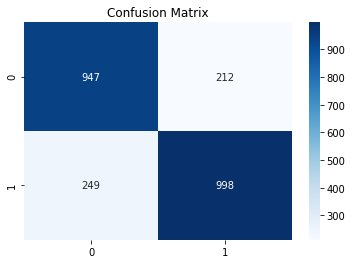

In [104]:
cm = confusion_matrix(lr_pipeline.predict(Xtest), Ytest)
ax = plt.axes()
sns.heatmap(cm, annot=True, annot_kws={"size": 10}, fmt='d',cmap="Blues", ax = ax )
ax.set_title('Confusion Matrix')
plt.show()

#### No Emoji conversion and no stop word removal 

In [105]:
training = data.copy()
X = training['comment']
Y = training['label']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=0)
Ytrain = Ytrain.astype('int')
Ytest = Ytest.astype('int')

In [106]:
lr_pipeline = make_pipeline( 
              TfidfVectorizer(stop_words=None, ngram_range=(1, 2)), 
              LogisticRegression(random_state=42)
          )

lr_pipeline.fit(Xtrain, Ytrain)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercep

##### Classification report

In [107]:

print(classification_report(lr_pipeline.predict(Xtest), Ytest))
lr_no = classification_report(lr_pipeline.predict(Xtest), Ytest)

              precision    recall  f1-score   support

           0       0.78      0.83      0.80      1123
           1       0.84      0.80      0.82      1283

    accuracy                           0.81      2406
   macro avg       0.81      0.81      0.81      2406
weighted avg       0.81      0.81      0.81      2406



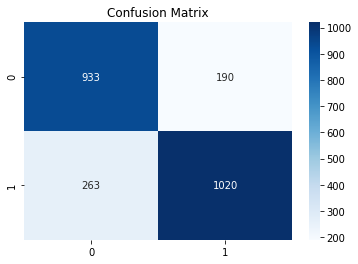

In [108]:
cm = confusion_matrix(lr_pipeline.predict(Xtest), Ytest)
ax = plt.axes()
sns.heatmap(cm, annot=True, annot_kws={"size": 10}, fmt='d',cmap="Blues", ax = ax )
ax.set_title('Confusion Matrix')
plt.show()

## Observations for Logistic Regression

In [109]:
#just converting emoji to words and not removing stop words
print(lr_emoji)

              precision    recall  f1-score   support

           0       0.78      0.83      0.80      1125
           1       0.84      0.79      0.82      1281

    accuracy                           0.81      2406
   macro avg       0.81      0.81      0.81      2406
weighted avg       0.81      0.81      0.81      2406



In [110]:
#Converting emojis to words and removing stop words
print(lr_emoji_sw)

              precision    recall  f1-score   support

           0       0.79      0.82      0.80      1159
           1       0.82      0.80      0.81      1247

    accuracy                           0.81      2406
   macro avg       0.81      0.81      0.81      2406
weighted avg       0.81      0.81      0.81      2406



In [111]:
#Keeping emojis and stop word
print(lr_no)

              precision    recall  f1-score   support

           0       0.78      0.83      0.80      1123
           1       0.84      0.80      0.82      1283

    accuracy                           0.81      2406
   macro avg       0.81      0.81      0.81      2406
weighted avg       0.81      0.81      0.81      2406



In [112]:
#Just removing stop words
print(lr_sw)

              precision    recall  f1-score   support

           0       0.79      0.82      0.81      1159
           1       0.83      0.80      0.81      1247

    accuracy                           0.81      2406
   macro avg       0.81      0.81      0.81      2406
weighted avg       0.81      0.81      0.81      2406



**By going through all the classification report for logestic regression, removing stop words increases the quality of the model to detect and correctly predict anti-vaccine comments. So the logestic model (with removing stop words and converting emoji's to word) can accurately predict 79% of anti-vaccine cases and accurately predict 83% of pro-vaccine case. In addition, the model can detect 82% of total anti-vaccine cases and 80% total pro-vaccine. By keeping emoji, we can get same performance but support for the cases in former model is more balanced.**

### Bernouilli's Naive Bayes

In [113]:
from sklearn.naive_bayes import BernoulliNB

#### Emoji Conversion and No stop word removal

In [114]:
training = data.copy()
training =emoji_convert(training)
training['comment'] = training['comment'].str.replace('[{}]'.format(string.punctuation), ' ')   # Removing punctuations

X = training['comment']
Y = training['label']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=0)
Ytrain = Ytrain.astype('int')
Ytest = Ytest.astype('int')

In [115]:
bnb_pipeline = make_pipeline( 
              TfidfVectorizer(stop_words=None, ngram_range=(1, 2)), 
              BernoulliNB()
          )

bnb_pipeline.fit(Xtrain, Ytrain)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('bernoullinb',
                 BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None,
                             fit_prior=True))],
         

##### Classification report

In [116]:
print("Bernouilli's Naive Bayes with no stop words removed: ")
Ypred = bnb_pipeline.predict(Xtest)
bnb_emoji =classification_report(Ypred, Ytest)
print(bnb_emoji)

Bernouilli's Naive Bayes with no stop words removed: 
              precision    recall  f1-score   support

           0       0.83      0.82      0.82      1198
           1       0.83      0.83      0.83      1208

    accuracy                           0.83      2406
   macro avg       0.83      0.83      0.83      2406
weighted avg       0.83      0.83      0.83      2406



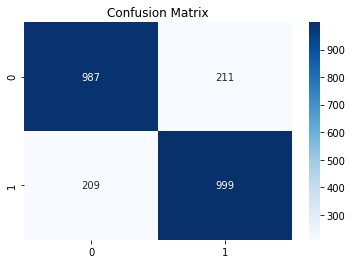

In [117]:
cm = confusion_matrix(bnb_pipeline.predict(Xtest), Ytest)
ax = plt.axes()
sns.heatmap(cm, annot=True, annot_kws={"size": 10}, fmt='d',cmap="Blues", ax = ax )
ax.set_title('Confusion Matrix')
plt.show()

#### Comments on what model have gone wrong.

In [118]:
# For pro-vaccination
for i in range(len(Ypred)):
  if Ypred[i] != Ytest.values[i] and Ytest.values[i]==1:
    print(Xtest.values[i])
    print('---')

because the mrna approach to vaccines is new  you might have seen claims and worries about what might happen after it’s injected into the body 
---
vaccines are meant to attack the host  so your body s immune system learns to defend itself against the actual virus  this is why antivaxxers are a thing because they believe that big pharm and governments are trying to kill them  but fact is they are too uneducated
---
although the vaccine is rushed that doesnt mean it isnt safe for use  they are not just skipping past the  testing phase   they are still taking many precautions to make sure its effects do more good than harm 
---
antivaxxers think the syringe and needle is for a horse but they are so tiny it fits in a babies hand 
---
i hate to tell you this  but everyone being vaccinated will not make americans normal 
---
i am      taking it 
---
i’m a pro vaxxer  anyone want to have a debate about vaccines 
---
uhhhhh they will be the ones alive you idiot 
---
I am not antivax but I am 

In [119]:
# For anti-vaccination
for i in range(len(Ypred)):
  if Ypred[i] != Ytest.values[i] and Ytest.values[i]==0:
    print(Xtest.values[i])
    print('---')

noooooo thank you      
---
i am very skeptical of it  i’m sorry i won’t get the vaccine  thats just my opinion
---
not vaccinating your kids only works fine so long as everyone around them is vaccinated 
---
the    year old man in astrazeneca s developed acute neuro encephalopathy  before that incident  a trial volunteer developed symptoms of transverse myelitis  it is a rare debilitating neurological disorder linked to vaccines  in september  a trial paused after another participant in the u k  got the same symptoms  in october  a participant in brazil died  what s more shocking is that mhra expects people to suffer from covid    vaccines 
---
i am more  scared  of the vaccine than i am of dying from covid  yeah  well said 
---
two mice are in the pub and one says “hey  have you had the new covid vaccine yet ” and the other replies“what   are you frickin crazy  they haven’t finished the human trials yet  ”
---
i like how this video supposed to make you feel like it’s no big deal get 

In [121]:
# Finding feature importances
feature_names = bnb_pipeline.named_steps["tfidfvectorizer"].get_feature_names()
importances = bnb_pipeline.steps[1][1].coef_

print(importances)

[[-7.97281078 -7.97281078 -7.97281078 ... -7.2796636  -7.97281078
  -7.97281078]]


In [122]:
df = pd.DataFrame(columns=["feature_names", "importances"])
df["feature_names"] = feature_names
df["importances"] = importances[0]
# print(len(importances))
# df

In [123]:
df.sort_values(by='importances',ascending=False)

,feature_names,importances
49050,the,-0.509448
52225,to,-0.784398
55428,vaccine,-0.791980
2250,and,-0.927034
26255,it,-1.190619
...,...,...
29868,mandated,-7.972811
29866,mandate healthy,-7.972811
29865,mandate exercise,-7.972811
29858,management of,-7.972811


#### No Emoji Conversion and stop word removal

In [124]:
training = data.copy()
X = training['comment']
Y = training['label']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=0)
Ytrain = Ytrain.astype('int')
Ytest = Ytest.astype('int')

In [125]:
bnb_pipeline = make_pipeline( 
              TfidfVectorizer(stop_words=nltk_stopwords, ngram_range=(1, 2)), 
              BernoulliNB()
          )

bnb_pipeline.fit(Xtrain, Ytrain)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'all', 'am',...
                                             'any', 'are', 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'by', 'can', 'd', 'did',
                 

##### Classification report

In [126]:
print("Bernouilli's Naive Bayes with no stop words removed: ")
print(classification_report(bnb_pipeline.predict(Xtest), Ytest))
bnb_sw = classification_report(bnb_pipeline.predict(Xtest), Ytest)

Bernouilli's Naive Bayes with no stop words removed: 
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1132
           1       0.85      0.80      0.82      1274

    accuracy                           0.82      2406
   macro avg       0.82      0.82      0.82      2406
weighted avg       0.82      0.82      0.82      2406



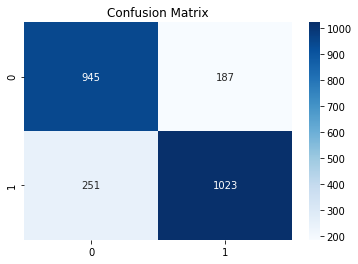

In [127]:
cm = confusion_matrix(bnb_pipeline.predict(Xtest), Ytest)
ax = plt.axes()
sns.heatmap(cm, annot=True, annot_kws={"size": 10}, fmt='d',cmap="Blues", ax = ax )
ax.set_title('Confusion Matrix')
plt.show()

#### Emoji Conversion and stop word removal

In [128]:
training = data.copy()
training =emoji_convert(training)
training['comment'] = training['comment'].str.replace('[{}]'.format(string.punctuation), ' ')   # Removing punctuations
X = training['comment']
Y = training['label']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=0)
Ytrain = Ytrain.astype('int')
Ytest = Ytest.astype('int')

In [129]:

bnb_pipeline = make_pipeline( 
              TfidfVectorizer(stop_words=nltk_stopwords, ngram_range=(1, 2)), 
              BernoulliNB()
          )

bnb_pipeline.fit(Xtrain, Ytrain)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'all', 'am',...
                                             'any', 'are', 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'by', 'can', 'd', 'did',
                 

##### Classification report

In [130]:
print("Bernouilli's Naive Bayes with no stop words removed: ")
print(classification_report(bnb_pipeline.predict(Xtest), Ytest))
bnb_emoji_sw = classification_report(bnb_pipeline.predict(Xtest), Ytest)

Bernouilli's Naive Bayes with no stop words removed: 
              precision    recall  f1-score   support

           0       0.79      0.84      0.81      1125
           1       0.85      0.80      0.82      1281

    accuracy                           0.82      2406
   macro avg       0.82      0.82      0.82      2406
weighted avg       0.82      0.82      0.82      2406



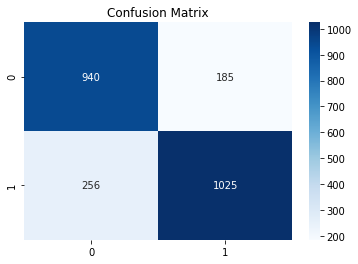

In [131]:
cm = confusion_matrix(bnb_pipeline.predict(Xtest), Ytest)
ax = plt.axes()
sns.heatmap(cm, annot=True, annot_kws={"size": 10}, fmt='d',cmap="Blues", ax = ax )
ax.set_title('Confusion Matrix')
plt.show()

#### No Emoji Conversion and No stop word removal

In [132]:
training = data.copy()
X = training['comment']
Y = training['label']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=0)
Ytrain = Ytrain.astype('int')
Ytest = Ytest.astype('int')

In [133]:
bnb_pipeline = make_pipeline( 
              TfidfVectorizer(stop_words=None, ngram_range=(1, 2)), 
              BernoulliNB(fit_prior='True')
          )

bnb_pipeline.fit(Xtrain, Ytrain)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('bernoullinb',
                 BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None,
                             fit_prior='True'))],
       

##### Classification report

In [134]:
print("Bernouilli's Naive Bayes with no stop words removed: ")
print(classification_report(bnb_pipeline.predict(Xtest), Ytest))
bnb_no = classification_report(bnb_pipeline.predict(Xtest), Ytest)

Bernouilli's Naive Bayes with no stop words removed: 
              precision    recall  f1-score   support

           0       0.83      0.82      0.83      1204
           1       0.82      0.83      0.83      1202

    accuracy                           0.83      2406
   macro avg       0.83      0.83      0.83      2406
weighted avg       0.83      0.83      0.83      2406



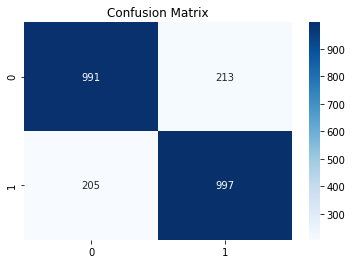

In [135]:
cm = confusion_matrix(bnb_pipeline.predict(Xtest), Ytest)
ax = plt.axes()
sns.heatmap(cm, annot=True, annot_kws={"size": 10}, fmt='d',cmap="Blues", ax = ax )
ax.set_title('Confusion Matrix')
plt.show()

## Observations made on Bernoulli's Naive Bayes

In [136]:
#Keeping emoji to words and not removing stop words
print(bnb_emoji)

              precision    recall  f1-score   support

           0       0.83      0.82      0.82      1198
           1       0.83      0.83      0.83      1208

    accuracy                           0.83      2406
   macro avg       0.83      0.83      0.83      2406
weighted avg       0.83      0.83      0.83      2406



In [137]:
#Converting emojis to words and removing stop words
print(bnb_emoji_sw)

              precision    recall  f1-score   support

           0       0.79      0.84      0.81      1125
           1       0.85      0.80      0.82      1281

    accuracy                           0.82      2406
   macro avg       0.82      0.82      0.82      2406
weighted avg       0.82      0.82      0.82      2406



In [138]:
#just converting emoji to words and not removing stop words
print(bnb_no)

              precision    recall  f1-score   support

           0       0.83      0.82      0.83      1204
           1       0.82      0.83      0.83      1202

    accuracy                           0.83      2406
   macro avg       0.83      0.83      0.83      2406
weighted avg       0.83      0.83      0.83      2406



In [139]:
#Just removing stop words
print(bnb_sw)

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1132
           1       0.85      0.80      0.82      1274

    accuracy                           0.82      2406
   macro avg       0.82      0.82      0.82      2406
weighted avg       0.82      0.82      0.82      2406



**By going through all the classification report for Bernouilli's naive bayes, removing stop words reduces the quality of the model to detect and correctly predict anti-vaccine comments. So the naive bayes (with keeping stop words and converting emoji's to word) can accurately predict 83% of anti-vaccine cases and accurately predict 83% of pro-vaccine case. In addition, the model can detect 83% of total anti-vaccine cases and 83% total pro-vaccine.**

### Stochastic Gradient Descent classfier

In [140]:
from sklearn.linear_model import SGDClassifier

#### Emoji conversion and No stop word removal

In [141]:
training = data.copy()
training =emoji_convert(training)
training['comment'] = training['comment'].str.replace('[{}]'.format(string.punctuation), ' ')   # Removing punctuations

X = training['comment']
Y = training['label']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=0)
Ytrain = Ytrain.astype('int')
Ytest = Ytest.astype('int')

In [142]:
sgd_pipeline = make_pipeline( 
              TfidfVectorizer(stop_words=None, ngram_range=(1, 2), strip_accents='unicode'), 
              SGDClassifier(random_state=42)
          )

sgd_pipeline.fit(Xtrain, Ytrain)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents='unicode',
                                 sublinear_tf=False,...
                ('sgdclassifier',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
           

##### Classification report

In [144]:
print("Stochastic gradient descent classifier with no stop words removed: ")
print(classification_report(sgd_pipeline.predict(Xtest), Ytest))
sgd_emoji = classification_report(sgd_pipeline.predict(Xtest), Ytest)

Stochastic gradient descent classifier with no stop words removed: 
              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1129
           1       0.86      0.81      0.83      1277

    accuracy                           0.83      2406
   macro avg       0.83      0.83      0.83      2406
weighted avg       0.83      0.83      0.83      2406



In [145]:
print("Stochastic gradient descent classifier with no stop words removed: ")
print(classification_report(sgd_pipeline.predict(Xtest), Ytest))

Stochastic gradient descent classifier with no stop words removed: 
              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1129
           1       0.86      0.81      0.83      1277

    accuracy                           0.83      2406
   macro avg       0.83      0.83      0.83      2406
weighted avg       0.83      0.83      0.83      2406



In [146]:
sns.heatmap(cm, annot=True, annot_kws={"size": 10}, fmt='d',cmap="Blues", ax = ax )
ax.set_title('Confusion Matrix')
plt.show()

#### No Emoji conversion and stop word removal

In [147]:
training = data.copy()
X = training['comment']
Y = training['label']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=0)
Ytrain = Ytrain.astype('int')
Ytest = Ytest.astype('int')

In [148]:
sgd_pipeline = make_pipeline( 
              TfidfVectorizer(stop_words=nltk_stopwords, ngram_range=(1, 2)), 
              SGDClassifier(random_state=42)
          )

sgd_pipeline.fit(Xtrain, Ytrain)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'all', 'am',...
                ('sgdclassifier',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hin

##### Classification report

In [149]:
print("Stochastic gradient descent classifier with no stop words removed: ")
print(classification_report(sgd_pipeline.predict(Xtest), Ytest))
sgd_sw = classification_report(sgd_pipeline.predict(Xtest), Ytest)

Stochastic gradient descent classifier with no stop words removed: 
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1154
           1       0.83      0.80      0.82      1252

    accuracy                           0.81      2406
   macro avg       0.81      0.81      0.81      2406
weighted avg       0.81      0.81      0.81      2406



In [150]:
sns.heatmap(cm, annot=True, annot_kws={"size": 10}, fmt='d',cmap="Blues", ax = ax )
ax.set_title('Confusion Matrix')
plt.show()

#### Emoji conversion and stop word removal

In [151]:
training = data.copy()
training =emoji_convert(training)
training['comment'] = training['comment'].str.replace('[{}]'.format(string.punctuation), ' ')   # Removing punctuations
X = training['comment']
Y = training['label']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=0)
Ytrain = Ytrain.astype('int')
Ytest = Ytest.astype('int')

In [152]:
sgd_pipeline = make_pipeline( 
              TfidfVectorizer(stop_words=nltk_stopwords, ngram_range=(1, 2)), 
              SGDClassifier(random_state=42)
          )

sgd_pipeline.fit(Xtrain, Ytrain)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'all', 'am',...
                ('sgdclassifier',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hin

##### Classification report

In [153]:
print("Stochastic Emoji gradient descent classifier with no stop words removed: ")
print(classification_report(sgd_pipeline.predict(Xtest), Ytest))
sgd_emoji_sw=classification_report(sgd_pipeline.predict(Xtest), Ytest)

Stochastic Emoji gradient descent classifier with no stop words removed: 
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1162
           1       0.83      0.80      0.82      1244

    accuracy                           0.81      2406
   macro avg       0.81      0.81      0.81      2406
weighted avg       0.81      0.81      0.81      2406



In [154]:
sns.heatmap(cm, annot=True, annot_kws={"size": 10}, fmt='d',cmap="Blues", ax = ax )
ax.set_title('Confusion Matrix')
plt.show()

#### No Emoji conversion and No stop word removal

In [156]:
training = data.copy()
X = training['comment']
Y = training['label']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=0)
Ytrain = Ytrain.astype('int')
Ytest = Ytest.astype('int')

In [157]:
sgd_pipeline = make_pipeline( 
              TfidfVectorizer(stop_words=None, ngram_range=(1, 2)), 
              SGDClassifier(random_state=42)
          )

sgd_pipeline.fit(Xtrain, Ytrain)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token...
                ('sgdclassifier',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='o

##### Classification report

In [158]:
print("Stochastic gradient descent classifier with no stop words removed: ")
print(classification_report(sgd_pipeline.predict(Xtest), Ytest))
sgd_no = classification_report(sgd_pipeline.predict(Xtest), Ytest)

Stochastic gradient descent classifier with no stop words removed: 
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1138
           1       0.86      0.82      0.84      1268

    accuracy                           0.83      2406
   macro avg       0.83      0.84      0.83      2406
weighted avg       0.84      0.83      0.83      2406



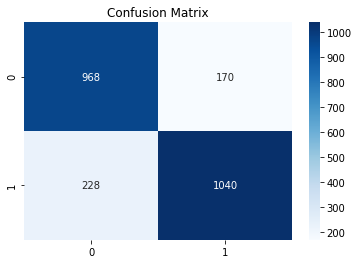

In [160]:
cm = confusion_matrix(sgd_pipeline.predict(Xtest), Ytest)
ax = plt.axes()
sns.heatmap(cm, annot=True, annot_kws={"size": 10}, fmt='d',cmap="Blues", ax = ax )
ax.set_title('Confusion Matrix')
plt.show()

## Observations made on Stochastic Gradient Descent Algorithm

In [161]:
#just converting emoji to words and no stop words removal
print(sgd_emoji)

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1129
           1       0.86      0.81      0.83      1277

    accuracy                           0.83      2406
   macro avg       0.83      0.83      0.83      2406
weighted avg       0.83      0.83      0.83      2406



In [162]:
#Converting emojis to words and removing stop words
print(sgd_emoji_sw)

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1162
           1       0.83      0.80      0.82      1244

    accuracy                           0.81      2406
   macro avg       0.81      0.81      0.81      2406
weighted avg       0.81      0.81      0.81      2406



In [163]:
#Keeping emojis and stop word
print(sgd_no)

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1138
           1       0.86      0.82      0.84      1268

    accuracy                           0.83      2406
   macro avg       0.83      0.84      0.83      2406
weighted avg       0.84      0.83      0.83      2406



In [164]:
#Just removing stop words
print(sgd_sw)

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1154
           1       0.83      0.80      0.82      1252

    accuracy                           0.81      2406
   macro avg       0.81      0.81      0.81      2406
weighted avg       0.81      0.81      0.81      2406



**By going through all the classification report for SGD, removing stop words reduces the quality of the model. So the SGD (without removing stop words and converting emoji's to word) can accurately predict 80% of anti-vaccine cases and accurately predict 86% of pro-vaccine case. In addition, the model can detect 85% of total anti-vaccine cases and 81% total pro-vaccine. By keeping emoji, we can get same performance but support for both cases in former model is more balanced.**

## Verdict

On comparing all four models, we can say that naive bayes performs equally well on both classes and better than other models. However, linear SVC can be used to identify pro-vaccine comments but performs little poorly for anti-vaccine comments. Therefore, it is better to use naive bayes to classify comments for pro or anti-vaccine comments.

## Evaluating on testing set

In [166]:
test_uploaded = files.upload()

Saving a3_test.tsv to a3_test.tsv


In [167]:
# data = pd.read_table("a3_train_final.tsv", header=None)
test_data = pd.read_table(io.BytesIO(test_uploaded['a3_test.tsv']), header=None)

In [168]:
test_data.columns = ['label','comment']

In [169]:
test_data.head()

,label,comment
0,0,#Poison
1,1,13k idiots. Natural selection. Let the people ...
2,0,3 versions of poison
3,1,90% is hugely effective! They're not done with...
4,1,A vaccine created in a year is an amazing achi...


In [170]:
test_data['label'].value_counts()

0    198
1    194
Name: label, dtype: int64

In [171]:
len(test_data)

392

In [172]:
Xtest_final = test_data['comment']
Ytest_final = test_data['label']

In [173]:
Ytest_final = Ytest_final.astype(int)

### Using Bernoulli's Naive Bayes

In [174]:
Ypred = bnb_pipeline.predict(Xtest_final)

In [175]:
print(classification_report(Ypred, Ytest_final))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89       189
           1       0.92      0.88      0.90       203

    accuracy                           0.90       392
   macro avg       0.90      0.90      0.90       392
weighted avg       0.90      0.90      0.90       392



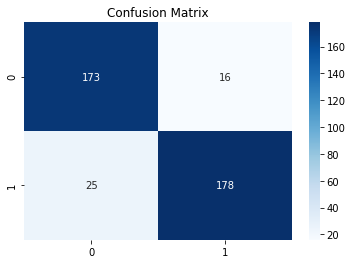

In [176]:
cm = confusion_matrix(Ypred, Ytest_final)
ax = plt.axes()
sns.heatmap(cm, annot=True, annot_kws={"size": 10}, fmt='d',cmap="Blues", ax = ax )
ax.set_title('Confusion Matrix')
plt.show()

We can observe that the number of false positives and false negatives is very low. And based on the classification report, we can determine that the model performance is pretty good.

### Using Linear SVC

In [177]:
Ypred = lsvc_pipeline.predict(Xtest_final)

In [178]:
print(classification_report(Ypred, Ytest_final))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       184
           1       0.92      0.86      0.89       208

    accuracy                           0.89       392
   macro avg       0.89      0.89      0.89       392
weighted avg       0.89      0.89      0.89       392



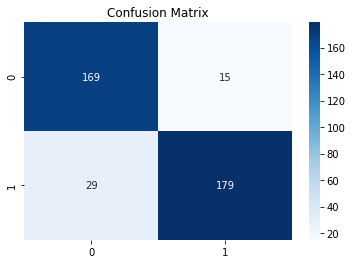

In [179]:
cm = confusion_matrix(Ypred, Ytest_final)
ax = plt.axes()
sns.heatmap(cm, annot=True, annot_kws={"size": 10}, fmt='d',cmap="Blues", ax = ax )
ax.set_title('Confusion Matrix')
plt.show()

Though there is no much difference in the accuracy scores, but the scores achieved for each label is lesser that the values achieved in Naive Bayes.